# Insurance Loss Analytics: Tweedie Regression Models

This notebook implements five different Tweedie regression models for predicting insurance loss metrics:
1. Loss Cost (LC)
2. Historically Adjusted Loss Cost (HALC)
3. Claim Status (CS) - binary classification

We'll compare different model variants and evaluate their performance.

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb

# Set styles for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Set random seed for reproducibility
np.random.seed(42)

import os

In [6]:
head, tail = os.path.split(os.getcwd())
os.chdir(os.path.join(head,'01_Data'))

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb

# Set styles for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Set random seed for reproducibility
np.random.seed(42)

## 1. Helper Functions

First, let's define some helper functions for data preprocessing and model evaluation.

In [10]:
def safe_drop_columns(df, columns_to_drop):
    """
    Safely drop columns from DataFrame, ignoring those that don't exist
    """
    existing_columns = [col for col in columns_to_drop if col in df.columns]
    
    if existing_columns:
        return df.drop(columns=existing_columns)
    else:
        return df.copy()

def clean_feature_names(df):
    """
    Clean feature names to make them compatible with LightGBM
    """
    # Create a mapping of old column names to new ones
    column_mapping = {}
    for col in df.columns:
        # Replace special characters with underscore
        new_col = re.sub(r'[^\w]', '_', str(col))
        
        # Ensure the column name starts with a letter
        if not new_col[0].isalpha():
            new_col = f'col_{new_col}'
            
        # Handle duplicates by adding a suffix
        suffix = 1
        temp_col = new_col
        while temp_col in column_mapping.values():
            temp_col = f"{new_col}_{suffix}"
            suffix += 1
        new_col = temp_col
        
        column_mapping[col] = new_col
    
    # Create a new DataFrame with cleaned column names
    df_clean = df.copy()
    df_clean.columns = [column_mapping[col] for col in df.columns]
    
    # Report changes
    changed_cols = [(old, new) for old, new in column_mapping.items() if old != new]
    if changed_cols:
        print(f"Cleaned {len(changed_cols)} column names for LightGBM compatibility")
    
    return df_clean

## 2. Data Loading and Preprocessing

In [11]:
def load_and_preprocess_data():
    """
    Load and preprocess the insurance data
    """
    print("Loading training data...")
    df_train = pd.read_csv('cleaned_data.csv')
    
    print(f"Training data shape: {df_train.shape}")
    print(f"Column names sample: {list(df_train.columns)[:5]}...")
    
    # Rename 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df_train.columns:
        df_train = df_train.rename(columns={'Unnamed: 0': 'row_index'})
    
    # Separate features and targets
    y_reg = df_train[['Loss_Cost', 'Historically_Adjusted_Loss_Cost']].fillna(0)
    y_cls = df_train[['Claim_Status']].fillna(0)
    
    # Check class distribution
    print(f"Claim distribution: {y_cls['Claim_Status'].value_counts()}")
    claim_rate = y_cls['Claim_Status'].mean() * 100
    print(f"Claim rate: {claim_rate:.2f}%")
    
    # Drop target variables and ID from features
    drop_columns = [
        'row_index', '', 'ID', 'Total_Cost_Claims_Current_Yr', 'Total_Number_Claims_Current_Yr',
        'Total_Number_Claims_Entire_Duration', 'Ratio_Claims_Total_Duration_Force', 
        'Loss_Cost', 'Historically_Adjusted_Loss_Cost', 'Claim_Status'
    ]
    
    X = safe_drop_columns(df_train, drop_columns)
    
    # Process date columns
    date_columns = ['Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal', 
                    'Date_Of_Birth', 'Date_Of_DL_Issuance']
    
    for col in date_columns:
        if col in X.columns:
            X[col] = pd.to_datetime(X[col], errors='coerce')
    
    # Create new features based on dates
    if all(col in X.columns for col in ['Start_Date_Contract', 'Date_Next_Renewal']):
        X['Contract_Duration'] = (X['Date_Next_Renewal'] - X['Start_Date_Contract']).dt.days
    
    if all(col in X.columns for col in ['Date_Last_Renewal', 'Date_Next_Renewal']):
        X['Last_Renewal_Gap'] = (X['Date_Next_Renewal'] - X['Date_Last_Renewal']).dt.days
    
    # Drop original date columns
    X = safe_drop_columns(X, date_columns)
    
    # One-hot encode categorical variables
    categorical_columns = []
    if 'Car_Age_Cat' in X.columns:
        categorical_columns.append('Car_Age_Cat')
    if 'Energy_Source' in X.columns:
        categorical_columns.append('Energy_Source')
    
    if categorical_columns:
        X = pd.get_dummies(X, columns=categorical_columns, drop_first=False)
    
    # Drop specific categories as done in original preprocessing
    cols_to_drop = [col for col in X.columns if col in ['Car_Age_Cat_New', 'Energy_Source_Other']]
    X = safe_drop_columns(X, cols_to_drop)
    
    # Handle missing values
    X = X.fillna(0)
    
    print(f"Processed features shape: {X.shape}")
    
    # Clean feature names for LightGBM compatibility
    X_clean = clean_feature_names(X)
    
    # Split data for training and validation
    X_train, X_val, y_reg_train, y_reg_val, y_cls_train, y_cls_val = train_test_split(
        X_clean, y_reg, y_cls, test_size=0.2, random_state=42, 
        stratify=y_cls  # Stratify based on claim status
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    
    return X_train, X_val, y_reg_train, y_reg_val, y_cls_train, y_cls_val, X_clean.columns

In [12]:
# Load and preprocess data
X_train, X_val, y_reg_train, y_reg_val, y_cls_train, y_cls_val, feature_names = load_and_preprocess_data()

Loading training data...
Training data shape: (37451, 47)
Column names sample: ['Unnamed: 0', 'ID', 'Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal']...
Claim distribution: Claim_Status
0    33300
1     4151
Name: count, dtype: int64
Claim rate: 11.08%
Processed features shape: (37451, 38)
Training set: 29960 samples
Validation set: 7491 samples


## 3. Implement Five Tweedie Regressor Models for Loss Cost (LC)

In [19]:
def train_tweedie_models_for_loss_cost(X_train, X_val, y_train, y_val):
    """
    Train five different Tweedie regression models for Loss Cost prediction
    """
    print("\nTraining Tweedie Regression Models for Loss Cost...")
    
    # Target variables
    y_train_lc = y_train['Loss_Cost']
    y_val_lc = y_val['Loss_Cost']
    
    # Model 1: Standard Tweedie Regressor with power=1.5
    model1 = TweedieRegressor(power=1.5, alpha=0.1, link='log')
    
    # Model 2: Tweedie Regressor with different power parameter
    model2 = TweedieRegressor(power=1.8, alpha=0.01, link='log')
    
    # Model 3: Gradient Boosting with Tweedie deviance
    model3 = GradientBoostingRegressor(
        loss='squared_error', learning_rate=0.05, 
        n_estimators=100, max_depth=5, random_state=42
    )
    
    # Model 4: LightGBM with Tweedie objective
    model4 = lgb.LGBMRegressor(
        objective='tweedie', tweedie_variance_power=1.5,
        n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42
    )
    
    # Model 5: LightGBM with different parameters
    model5 = lgb.LGBMRegressor(
        objective='tweedie', tweedie_variance_power=1.8,
        n_estimators=200, learning_rate=0.01, max_depth=7, random_state=42
    )
    
    models = {
        'Standard Tweedie (power=1.5)': model1,
        'Tweedie (power=1.8)': model2,
        'Gradient Boosting (gamma loss)': model3,
        'LightGBM Tweedie (power=1.5)': model4,
        'LightGBM Tweedie (power=1.8)': model5
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Train model
        model.fit(X_train, y_train_lc)
        
        # Make predictions
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        # Calculate RMSE
        train_rmse = np.sqrt(mean_squared_error(y_train_lc, train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val_lc, val_pred))
        
        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'val_predictions': val_pred
        }
        
        print(f"  Train RMSE: {train_rmse:.4f}")
        print(f"  Validation RMSE: {val_rmse:.4f}")
    
    # Create a summary table
    summary = pd.DataFrame({
        'Model': list(results.keys()),
        'Train RMSE': [results[model]['train_rmse'] for model in results],
        'Validation RMSE': [results[model]['val_rmse'] for model in results]
    }).sort_values('Validation RMSE')
    
    return results, summary

In [20]:
# Train Loss Cost models
lc_results, lc_summary = train_tweedie_models_for_loss_cost(X_train, X_val, y_reg_train, y_reg_val)

# Display results summary
print("\nLoss Cost Model Performance Summary:")
display(lc_summary)


Training Tweedie Regression Models for Loss Cost...
Training Standard Tweedie (power=1.5)...
  Train RMSE: 880.1444
  Validation RMSE: 646.6224
Training Tweedie (power=1.8)...
  Train RMSE: 880.1444
  Validation RMSE: 646.6224
Training Gradient Boosting (gamma loss)...
  Train RMSE: 465.9044
  Validation RMSE: 641.4786
Training LightGBM Tweedie (power=1.5)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 36
[LightGBM] [Info] Start training from score 4.240459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

,Model,Train RMSE,Validation RMSE
3,LightGBM Tweedie (power=1.5),847.802847,640.431867
2,Gradient Boosting (gamma loss),465.904387,641.478561
4,LightGBM Tweedie (power=1.8),873.072793,641.740934
0,Standard Tweedie (power=1.5),880.144382,646.622369
1,Tweedie (power=1.8),880.144382,646.622369


## 4. Implement Five Tweedie Regressor Models for HALC

In [21]:
def train_tweedie_models_for_halc(X_train, X_val, y_train, y_val):
    """
    Train five different Tweedie regression models for HALC prediction
    """
    print("\nTraining Tweedie Regression Models for Historically Adjusted Loss Cost...")
    
    # Target variables
    y_train_halc = y_train['Historically_Adjusted_Loss_Cost']
    y_val_halc = y_val['Historically_Adjusted_Loss_Cost']
    
    # Model 1: Standard Tweedie Regressor with power=1.5
    model1 = TweedieRegressor(power=1.5, alpha=0.1, link='log')
    
    # Model 2: Tweedie Regressor with different power parameter
    model2 = TweedieRegressor(power=1.8, alpha=0.01, link='log')
    
    # Model 3: Gradient Boosting with Tweedie deviance
    model3 = GradientBoostingRegressor(
        loss='squared_error', learning_rate=0.05, 
        n_estimators=100, max_depth=5, random_state=42
    )
    
    # Model 4: LightGBM with Tweedie objective
    model4 = lgb.LGBMRegressor(
        objective='tweedie', tweedie_variance_power=1.5,
        n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42
    )
    
    # Model 5: LightGBM with different parameters
    model5 = lgb.LGBMRegressor(
        objective='tweedie', tweedie_variance_power=1.8,
        n_estimators=200, learning_rate=0.01, max_depth=7, random_state=42
    )
    
    models = {
        'Standard Tweedie (power=1.5)': model1,
        'Tweedie (power=1.8)': model2,
        'Gradient Boosting (gamma loss)': model3,
        'LightGBM Tweedie (power=1.5)': model4,
        'LightGBM Tweedie (power=1.8)': model5
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Train model
        model.fit(X_train, y_train_halc)
        
        # Make predictions
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        # Calculate RMSE
        train_rmse = np.sqrt(mean_squared_error(y_train_halc, train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val_halc, val_pred))
        
        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'val_predictions': val_pred
        }
        
        print(f"  Train RMSE: {train_rmse:.4f}")
        print(f"  Validation RMSE: {val_rmse:.4f}")
    
    # Create a summary table
    summary = pd.DataFrame({
        'Model': list(results.keys()),
        'Train RMSE': [results[model]['train_rmse'] for model in results],
        'Validation RMSE': [results[model]['val_rmse'] for model in results]
    }).sort_values('Validation RMSE')
    
    return results, summary

In [22]:
# Train HALC models
halc_results, halc_summary = train_tweedie_models_for_halc(X_train, X_val, y_reg_train, y_reg_val)

# Display results summary
print("\nHistorically Adjusted Loss Cost Model Performance Summary:")
display(halc_summary)


Training Tweedie Regression Models for Historically Adjusted Loss Cost...
Training Standard Tweedie (power=1.5)...
  Train RMSE: 1766.5374
  Validation RMSE: 1179.1685
Training Tweedie (power=1.8)...
  Train RMSE: 1766.5374
  Validation RMSE: 1179.1685
Training Gradient Boosting (gamma loss)...
  Train RMSE: 937.4967
  Validation RMSE: 1198.1443
Training LightGBM Tweedie (power=1.5)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 36
[LightGBM] [Info] Start training from score 4.861695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,Model,Train RMSE,Validation RMSE
3,LightGBM Tweedie (power=1.5),1698.979954,1168.780038
4,LightGBM Tweedie (power=1.8),1752.538596,1170.881434
0,Standard Tweedie (power=1.5),1766.537405,1179.168516
1,Tweedie (power=1.8),1766.537405,1179.168516
2,Gradient Boosting (gamma loss),937.496681,1198.144331


## 5. Implement Five Classification Models for Claim Status (CS)

In [23]:
def train_classification_models(X_train, X_val, y_train, y_val):
    """
    Train five different classification models for predicting Claim Status
    """
    print("\nTraining Classification Models for Claim Status...")
    
    # Target variable
    y_train_cs = y_train['Claim_Status']
    y_val_cs = y_val['Claim_Status']
    
    # Model 1: Random Forest Classifier
    model1 = RandomForestClassifier(
        n_estimators=100, max_depth=5, random_state=42, class_weight='balanced'
    )
    
    # Model 2: Gradient Boosting Classifier
    model2 = GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    )
    
    # Model 3: LightGBM classifier with balanced classes
    model3 = lgb.LGBMClassifier(
        n_estimators=100, learning_rate=0.05, max_depth=5, 
        class_weight='balanced', random_state=42
    )
    
    # Model 4: LightGBM with different parameters
    model4 = lgb.LGBMClassifier(
        n_estimators=200, learning_rate=0.01, max_depth=7, 
        class_weight='balanced', random_state=42
    )
    
    # Model 5: LightGBM with focal loss (for highly imbalanced data)
    model5 = lgb.LGBMClassifier(
        objective='binary', boosting_type='goss',
        n_estimators=150, learning_rate=0.02, max_depth=6,
        scale_pos_weight=10, random_state=42
    )
    
    models = {
        'Random Forest': model1,
        'Gradient Boosting': model2,
        'LightGBM (balanced)': model3,
        'LightGBM (tuned)': model4,
        'LightGBM (focal loss approx)': model5
    }
    
    results = {}
    all_fpr = {}
    all_tpr = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Train model
        model.fit(X_train, y_train_cs)
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # For ROC-AUC, we need probability estimates
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_val_prob = model.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        train_acc = accuracy_score(y_train_cs, y_train_pred)
        val_acc = accuracy_score(y_val_cs, y_val_pred)
        
        train_auc = roc_auc_score(y_train_cs, y_train_prob)
        val_auc = roc_auc_score(y_val_cs, y_val_prob)
        
        val_precision = precision_score(y_val_cs, y_val_pred)
        val_recall = recall_score(y_val_cs, y_val_pred)
        val_f1 = f1_score(y_val_cs, y_val_pred)
        
        # Calculate ROC curve points
        fpr, tpr, _ = roc_curve(y_val_cs, y_val_prob)
        all_fpr[name] = fpr
        all_tpr[name] = tpr
        
        results[name] = {
            'model': model,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'train_auc': train_auc,
            'val_auc': val_auc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'val_probabilities': y_val_prob
        }
        
        print(f"  Train Accuracy: {train_acc:.4f}, AUC: {train_auc:.4f}")
        print(f"  Val Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}")
        print(f"  Val Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    
    # Create a summary table
    summary = pd.DataFrame({
        'Model': list(results.keys()),
        'AUC': [results[model]['val_auc'] for model in results],
        'Accuracy': [results[model]['val_acc'] for model in results],
        'Precision': [results[model]['val_precision'] for model in results],
        'Recall': [results[model]['val_recall'] for model in results],
        'F1 Score': [results[model]['val_f1'] for model in results]
    }).sort_values('AUC', ascending=False)
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    for name in results.keys():
        plt.plot(all_fpr[name], all_tpr[name], lw=2, 
                 label=f'{name} (AUC = {results[name]["val_auc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Claim Status Prediction')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return results, summary, plt


Training Classification Models for Claim Status...
Training Random Forest...
  Train Accuracy: 0.7410, AUC: 0.8080
  Val Accuracy: 0.7305, AUC: 0.7847
  Val Precision: 0.2463, Recall: 0.6952, F1: 0.3637
Training Gradient Boosting...
  Train Accuracy: 0.9096, AUC: 0.8747
  Val Accuracy: 0.8947, AUC: 0.8019
  Val Precision: 0.5972, Recall: 0.1518, F1: 0.2421
Training LightGBM (balanced)...
[LightGBM] [Info] Number of positive: 3321, number of negative: 26639
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 29960, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive 

,Model,AUC,Accuracy,Precision,Recall,F1 Score
4,LightGBM (focal loss approx),0.805132,0.703511,0.236253,0.750602,0.359389
2,LightGBM (balanced),0.803628,0.740489,0.256769,0.708434,0.376923
1,Gradient Boosting,0.801869,0.894674,0.597156,0.151807,0.242075
3,LightGBM (tuned),0.799163,0.726338,0.247098,0.718072,0.367674
0,Random Forest,0.784729,0.730477,0.246265,0.695181,0.363694


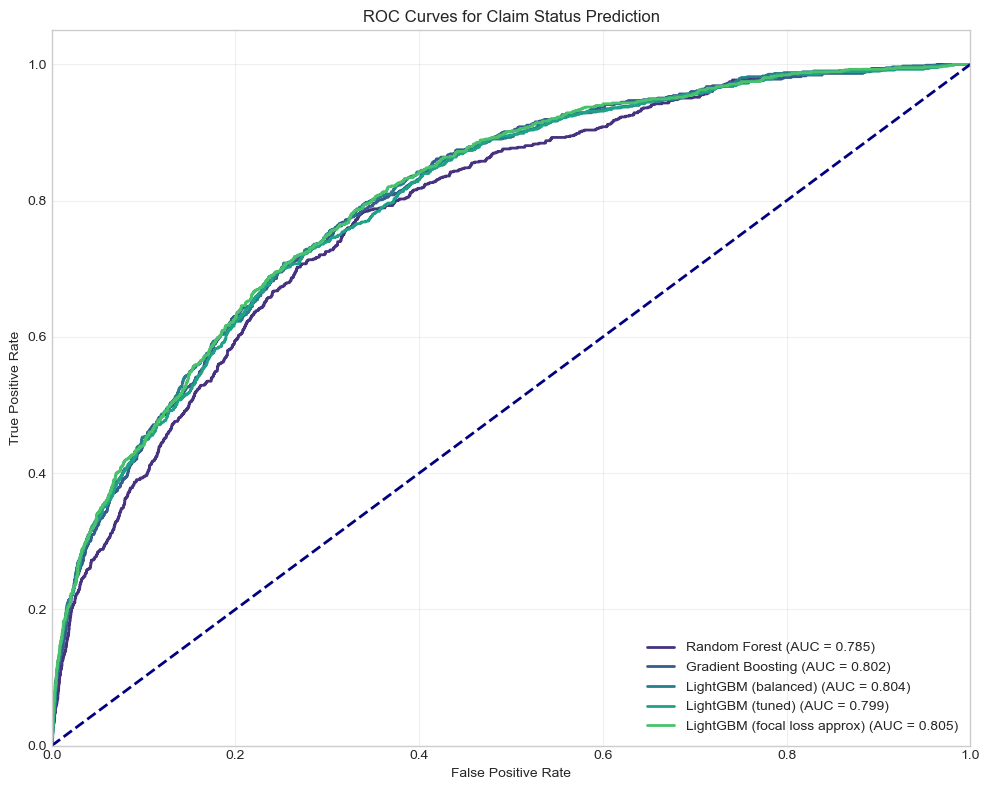

In [24]:
# Train Claim Status models
cs_results, cs_summary, roc_plot = train_classification_models(X_train, X_val, y_cls_train, y_cls_val)

# Display results summary
print("\nClaim Status Model Performance Summary:")
display(cs_summary)

# Display ROC plot
roc_plot.show()

## 6. Feature Importance Analysis

In [25]:
def plot_feature_importance(model, feature_names, title, top_n=15):
    """
    Plot feature importance for the models
    """
    # Get feature importance
    importance = model.feature_importances_
    
    # Create DataFrame for plotting
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Importance', y='Feature', data=feat_imp)
    
    # Add values to bars
    for i, v in enumerate(feat_imp['Importance']):
        ax.text(v + 0.001, i, f"{v:.4f}", va='center')
        
    plt.title(title, fontsize=16)
    plt.tight_layout()
    
    return plt, feat_imp

Best Loss Cost model: LightGBM Tweedie (power=1.5)
Best HALC model: LightGBM Tweedie (power=1.5)
Best Claim Status model: LightGBM (focal loss approx)


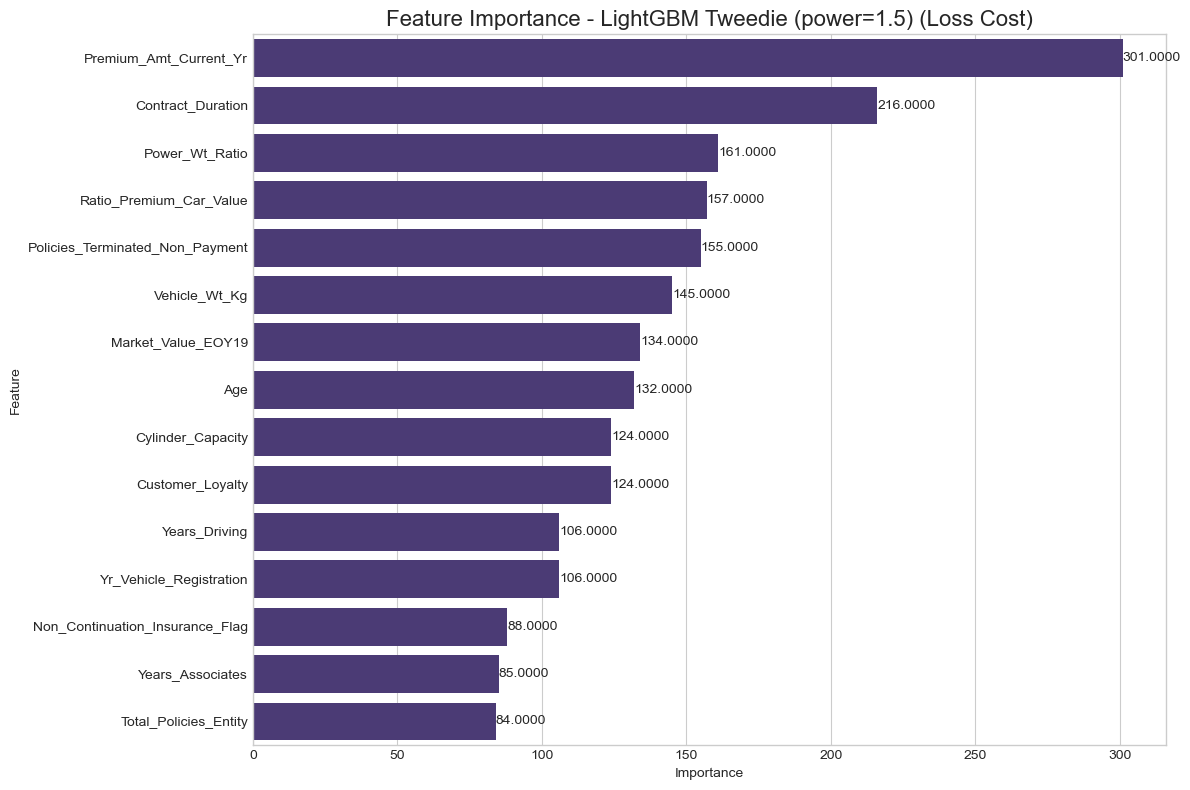

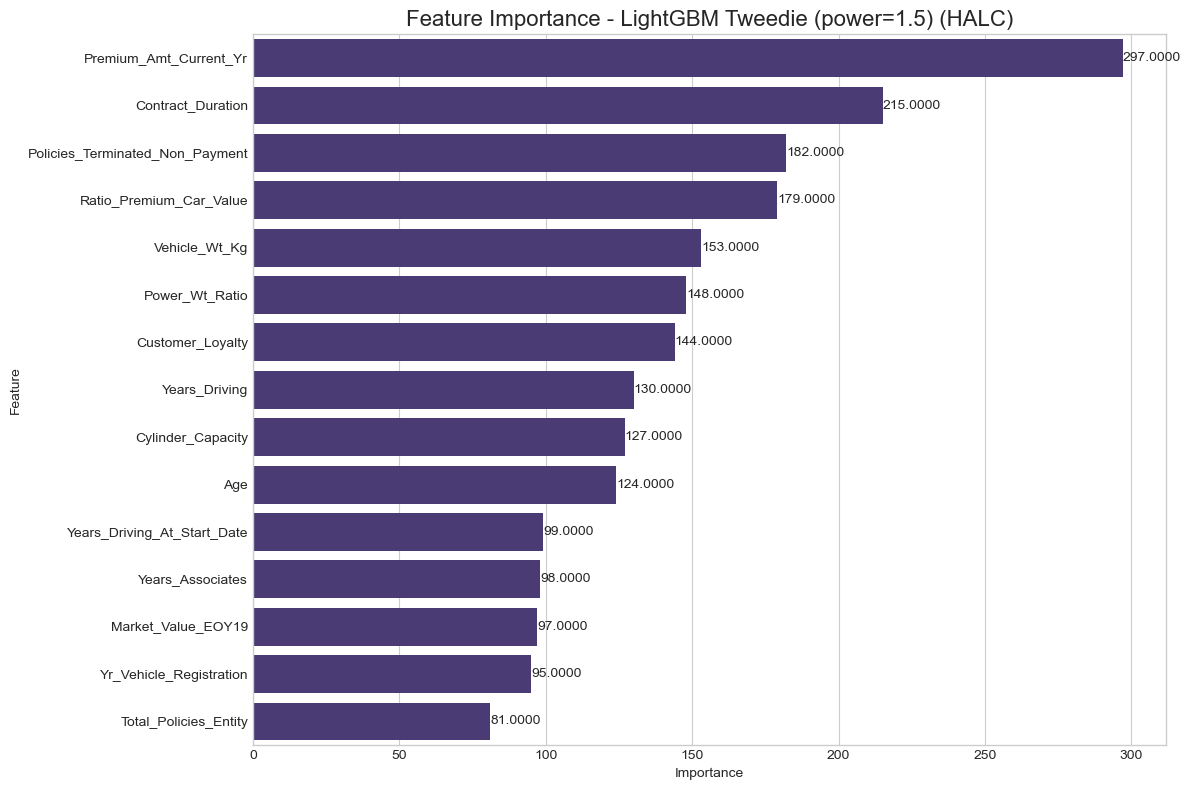

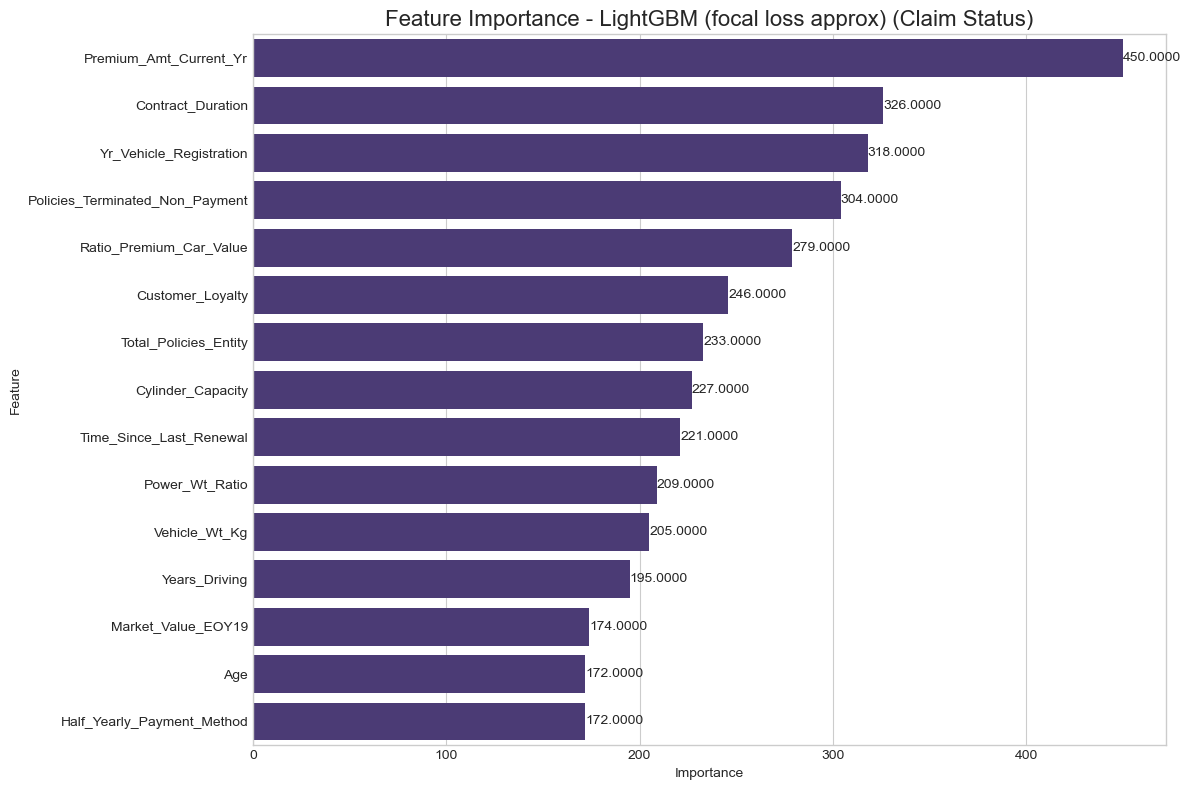

In [26]:
# Get best models
best_lc_model_name = lc_summary.iloc[0]['Model']
best_halc_model_name = halc_summary.iloc[0]['Model']
best_cs_model_name = cs_summary.iloc[0]['Model']

print(f"Best Loss Cost model: {best_lc_model_name}")
print(f"Best HALC model: {best_halc_model_name}")
print(f"Best Claim Status model: {best_cs_model_name}")

# Plot feature importance for best models
lc_plot, _ = plot_feature_importance(
    lc_results[best_lc_model_name]['model'], 
    feature_names, 
    f"Feature Importance - {best_lc_model_name} (Loss Cost)"
)
lc_plot.show()

halc_plot, _ = plot_feature_importance(
    halc_results[best_halc_model_name]['model'], 
    feature_names, 
    f"Feature Importance - {best_halc_model_name} (HALC)"
)
halc_plot.show()

cs_plot, _ = plot_feature_importance(
    cs_results[best_cs_model_name]['model'], 
    feature_names, 
    f"Feature Importance - {best_cs_model_name} (Claim Status)"
)
cs_plot.show()

## 7. Predictions on Test Data

In [27]:
def load_and_preprocess_test_data(train_columns):
    """
    Load and preprocess the test data
    """
    print("Loading test data...")
    df_test = pd.read_csv('cleaned_test.csv')
    
    print(f"Test data shape: {df_test.shape}")
    
    # Rename 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df_test.columns:
        df_test = df_test.rename(columns={'Unnamed: 0': 'row_index'})
    
    # Drop unnecessary columns
    X_test = safe_drop_columns(df_test, ['row_index', ''])
    
    # Process date columns
    date_columns = ['Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal', 
                    'Date_Of_Birth', 'Date_Of_DL_Issuance']
    
    for col in date_columns:
        if col in X_test.columns:
            X_test[col] = pd.to_datetime(X_test[col], errors='coerce')
    
    # Create new features based on dates
    if all(col in X_test.columns for col in ['Start_Date_Contract', 'Date_Next_Renewal']):
        X_test['Contract_Duration'] = (X_test['Date_Next_Renewal'] - X_test['Start_Date_Contract']).dt.days
    
    if all(col in X_test.columns for col in ['Date_Last_Renewal', 'Date_Next_Renewal']):
        X_test['Last_Renewal_Gap'] = (X_test['Date_Next_Renewal'] - X_test['Date_Last_Renewal']).dt.days
    
    # Drop original date columns
    X_test = safe_drop_columns(X_test, date_columns)
    
    # One-hot encode categorical variables
    categorical_columns = []
    if 'Car_Age_Cat' in X_test.columns:
        categorical_columns.append('Car_Age_Cat')
    if 'Energy_Source' in X_test.columns:
        categorical_columns.append('Energy_Source')
    
    if categorical_columns:
        X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=False)
    
    # Drop specific categories
    cols_to_drop = [col for col in X_test.columns if col in ['Car_Age_Cat_New', 'Energy_Source_Other']]
    X_test = safe_drop_columns(X_test, cols_to_drop)
    
    # Handle missing values
    X_test = X_test.fillna(0)
    
    # Clean column names
    X_test_clean = clean_feature_names(X_test)
    
    # Align columns with training data
    missing_cols = set(train_columns) - set(X_test_clean.columns)
    for col in missing_cols:
        X_test_clean[col] = 0
    
    # Ensure the same column order
    X_test_clean = X_test_clean[train_columns]
    
    print(f"Processed test data shape: {X_test_clean.shape}")
    
    return X_test_clean

In [28]:
# Load and preprocess test data
X_test = load_and_preprocess_test_data(feature_names)

# Get best models
best_lc_model = lc_results[best_lc_model_name]['model']
best_halc_model = halc_results[best_halc_model_name]['model']
best_cs_model = cs_results[best_cs_model_name]['model']

# Make predictions
lc_preds = best_lc_model.predict(X_test)
halc_preds = best_halc_model.predict(X_test)
cs_probs = best_cs_model.predict_proba(X_test)[:, 1]
cs_preds = (cs_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Create prediction DataFrame
predictions = pd.DataFrame({
    'LC': lc_preds,
    'HALC': halc_preds,
    'CS': cs_preds
})

# Display first few predictions
print("\nSample predictions:")
display(predictions.head())

# Save predictions to CSV
predictions.to_csv('group_x_prediction.csv', index=False)
print("\nPredictions saved to 'group_x_prediction.csv'")

Loading test data...
Test data shape: (15787, 39)
Processed test data shape: (15787, 38)
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.

Sample predictions:


,LC,HALC,CS
0,18.477184,40.089799,0
1,42.115387,52.430416,0
2,57.201794,114.001061,1
3,31.517294,21.859430,0
4,1.777395,2.397106,0



Predictions saved to 'group_x_prediction.csv'


## 8. Summary and Conclusion

In [29]:
# Display summary of best models
print("\nSummary of Best Models:")
print("-" * 60)

print(f"Best Loss Cost model: {best_lc_model_name}")
print(f"  Validation RMSE: {lc_results[best_lc_model_name]['val_rmse']:.4f}")

print(f"\nBest HALC model: {best_halc_model_name}")
print(f"  Validation RMSE: {halc_results[best_halc_model_name]['val_rmse']:.4f}")

print(f"\nBest Claim Status model: {best_cs_model_name}")
print(f"  Validation AUC: {cs_results[best_cs_model_name]['val_auc']:.4f}")
print(f"  Validation Precision: {cs_results[best_cs_model_name]['val_precision']:.4f}")
print(f"  Validation Recall: {cs_results[best_cs_model_name]['val_recall']:.4f}")
print(f"  Validation F1: {cs_results[best_cs_model_name]['val_f1']:.4f}")

# Analyze prediction distributions
print("\nPrediction Distributions:")
print("-" * 60)

print("Loss Cost:")
print(f"  Mean: {predictions['LC'].mean():.4f}")
print(f"  Min: {predictions['LC'].min():.4f}")
print(f"  Max: {predictions['LC'].max():.4f}")
print(f"  Zero values: {(predictions['LC'] == 0).sum()} ({(predictions['LC'] == 0).mean()*100:.2f}%)")

print("\nHistorically Adjusted Loss Cost:")
print(f"  Mean: {predictions['HALC'].mean():.4f}")
print(f"  Min: {predictions['HALC'].min():.4f}")
print(f"  Max: {predictions['HALC'].max():.4f}")
print(f"  Zero values: {(predictions['HALC'] == 0).sum()} ({(predictions['HALC'] == 0).mean()*100:.2f}%)")

print("\nClaim Status:")
print(f"  Claim rate: {predictions['CS'].mean()*100:.2f}%")
print(f"  Claims: {predictions['CS'].sum()} out of {len(predictions)}")


Summary of Best Models:
------------------------------------------------------------
Best Loss Cost model: LightGBM Tweedie (power=1.5)
  Validation RMSE: 640.4319

Best HALC model: LightGBM Tweedie (power=1.5)
  Validation RMSE: 1168.7800

Best Claim Status model: LightGBM (focal loss approx)
  Validation AUC: 0.8051
  Validation Precision: 0.2363
  Validation Recall: 0.7506
  Validation F1: 0.3594

Prediction Distributions:
------------------------------------------------------------
Loss Cost:
  Mean: 51.9203
  Min: 0.0397
  Max: 966.5824
  Zero values: 0 (0.00%)

Historically Adjusted Loss Cost:
  Mean: 94.9544
  Min: 0.0604
  Max: 2003.9104
  Zero values: 0 (0.00%)

Claim Status:
  Claim rate: 35.03%
  Claims: 5530 out of 15787
